### Imports and Helper

In [160]:
import pandas as pd
import librosa as lr
import librosa.display as lrd
import time
import warnings
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
from torch import Tensor
import torch
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.optim import Adam, SGD
from torch.utils.data import Dataset
import math
import datetime

# Dataset

In [161]:
from librosa import util
from joblib import Parallel, delayed
from tqdm import tqdm

In [162]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [163]:
from customdataset import WindowedAudioDataset

In [164]:
audio_base_path = 'data/MEMD_audio/'
arousal_file = 'data/annotations/annotations averaged per song/dynamic (per second annotations)/arousal.csv'
valence_file = 'data/annotations/annotations averaged per song/dynamic (per second annotations)/valence.csv'
dataset_path = '/content/drive/MyDrive/seminararbeit/dataset_rnn.torchdata'

In [165]:
#deam_dataset = WindowedAudioDataset(arousal_file,
#                                    valence_file,
#                                    audio_base_path,
#                                    window_length=25.0,
#                                    window_hopsize=999.9,
#                                    mfcc_features=50,
#                                    feature_hop_len=22050,
#                                    feature_window_size=22050,
#                                    sequence_annotation=True
#                                    )

In [166]:
#deam_dataset.generate_x_y(worker=4)

In [167]:
#deam_dataset.mode = 'mfcc_last_sequence'

In [168]:
#torch.save(deam_dataset, dataset_path, pickle_protocol=4)
deam_dataset = torch.load(dataset_path)

In [169]:
len(deam_dataset.labels)

1802

In [55]:
deam_dataset.mode = 'mfcc_last_sequence'

In [170]:
deam_dataset[0][1].size()

torch.Size([50, 2])

# Model

In [171]:
from sklearn.metrics import r2_score

In [15]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Subset
from torch.utils.data.sampler import SubsetRandomSampler
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [58]:
batch_size = 32
validation_split = .2
shuffle_dataset = True
random_seed = 42
train_size = int(0.8 * len(deam_dataset))
test_size = len(deam_dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(deam_dataset, [train_size, test_size])

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)
validation_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)


In [59]:
for x, y in train_loader:
    print(x.size())
    break

torch.Size([32, 50, 50])


### Model

In [115]:
class LSTMNet(nn.Module):

    def __init__(self, embedding_dim=50, hidden_dim=64, target_size=2, dropout=0.1):
        super(LSTMNet, self).__init__()
        self.hidden_dim = hidden_dim

        # The LSTM takes word embeddings as inputs, and outputs hidden states
        # with dimensionality hidden_dim.
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, dropout=dropout, num_layers=24, batch_first=False)

        # The linear layer that maps from hidden state space to tag space
        self.embedding_dim = 50

        self.linear = nn.Linear(hidden_dim, 32, bias=True)
        self.relu = nn.ReLU(inplace=False)
        self.linear2 = nn.Linear(32, 2, bias=True)
        self.dropout1 = nn.Dropout(0.1, inplace=False)

    def forward(self, x):
        batch_size = len(x)
        h_0 = Variable(torch.zeros(24, batch_size, self.hidden_dim).to(device))
        c_0 = Variable(torch.zeros(24, batch_size, self.hidden_dim).to(device))
        x = x.view(x.size()[1], batch_size, -1)

        output, (final_hidden_state, final_cell_state) = self.lstm(x)
        x = self.dropout1(self.relu(self.linear(output[-1])))
        x = self.linear2(x)
        return x

In [145]:
net = LSTMNet().to(device)

In [146]:
"""test = TransformerModel(
    ntoken=2,
    d_model=256,
    nhead=2,
    d_hid=256,
    nlayers=2,
    dropout=0.2,

).to(device)"""

'test = TransformerModel(\n    ntoken=2,\n    d_model=256,\n    nhead=2,\n    d_hid=256,\n    nlayers=2,\n    dropout=0.2,\n\n).to(device)'

In [147]:
testdata = deam_dataset[0][0][None, :, :]

In [148]:
testdata.size()


torch.Size([1, 50, 50])

In [149]:

pred = net(testdata.to(device))


In [150]:
pred.size()

torch.Size([1, 2])

In [151]:
torch.Tensor(deam_dataset.labels[0][-1])[None, :].size()

torch.Size([1, 2])

In [152]:
deam_dataset[0][1].size()

torch.Size([2])

In [153]:
def get_n_params(model):
    pp=0
    for p in list(model.parameters()):
        nn=1
        for s in list(p.size()):
            nn = nn*s
        pp += nn
    return pp

In [154]:
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [158]:
def train(model, epochs=40):
    train_loss = []
    val_loss = []
    for epoch in tqdm(range(epochs)):

        sum_loss = 0.0
        sum_r2 = 0.0
        with torch.set_grad_enabled(False):
            for x, y in validation_loader:
                pred = model(x.to(device))
                loss = criterion(pred, y.to(device))
                sum_loss += loss.item()
                sum_r2 += r2_score(y.flatten(), pred.cpu().flatten())
            val_loss.append([epoch, sum_loss / len(validation_loader), sum_r2 / len(validation_loader)])

        for i, (x, y) in enumerate(train_loader, 0):
                optimizer.zero_grad()
                pred = model(x.to(device))
                loss = criterion(pred, y.to(device))
                loss.backward()
                optimizer.step()
                train_loss.append([float(epoch + i/len(train_loader)), loss.item()])

    return np.array(train_loss), np.array(val_loss)

train_loss, val_loss = train(net)

100%|██████████| 40/40 [01:28<00:00,  2.20s/it]


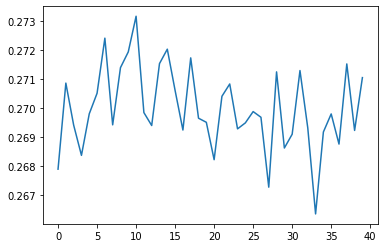

In [159]:
plt.plot(val_loss[0:, 0], np.sqrt(val_loss[0:, 1]))

min:  0.2659792950665783


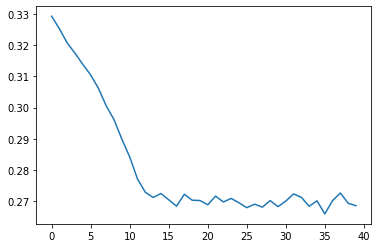

In [128]:
plt.plot(val_loss[:, 0], np.sqrt(val_loss[:, 1]))
print('min: ', np.min(np.sqrt(val_loss[:, 1])))

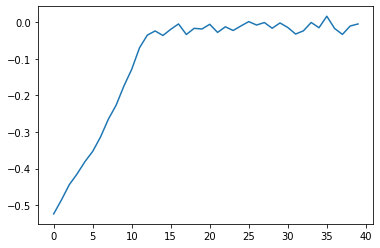

In [129]:
plt.plot(val_loss[:, 0], val_loss[:, 2])

In [130]:
for x, y in train_loader:
    print(x.size())
    print(y.size())
    break

torch.Size([32, 50, 50])
torch.Size([32, 2])


100%|██████████| 150/150 [06:29<00:00,  2.60s/it]


Validation RMSE: 
 Max: 	 0.25 
 Min: 	 0.21 
 Mean: 	 0.22 
 std: 	 0.01 
 
 Arousel RMSE: 
 Max: 	 0.27 
 Min: 	 0.23 
 Mean: 	 0.24 
 std: 	 0.01 
 
 Valence RMSE: 
 Max: 	 0.22 
 Min: 	 0.19 
 Mean: 	 0.20 
 std: 	 0.01 
 
 R2: 
 Max: 	 0.25 
 Min: 	 -0.09 
 Mean: 	 0.15 
 std: 	 0.05 
 
 


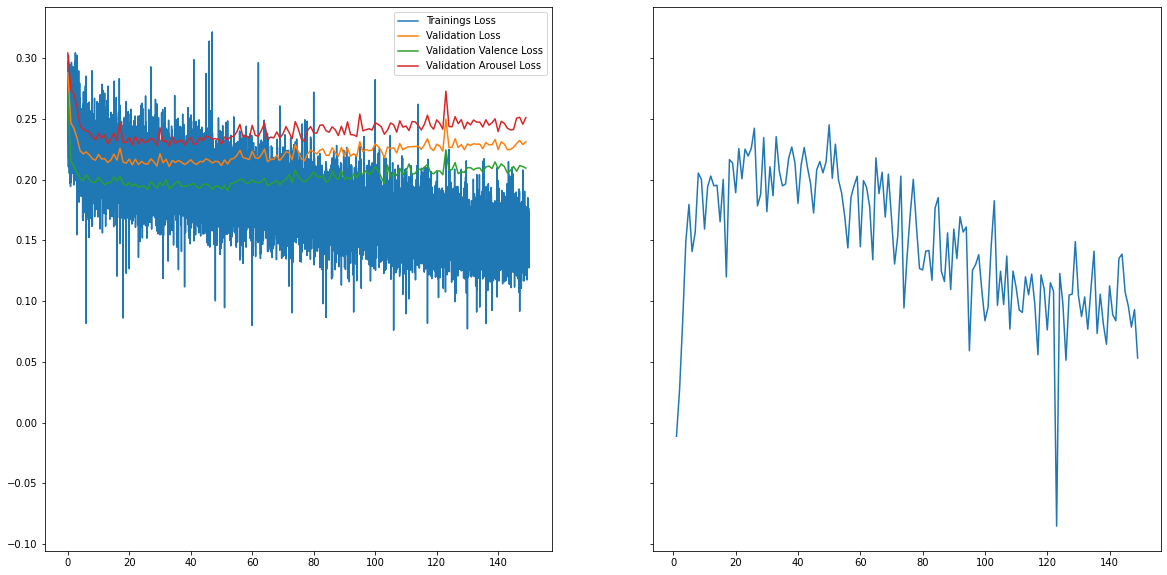

In [ ]:
print_stats(val_loss, train_loss, 10)

In [ ]:
def print_stats(val_loss, train_loss, start_mean_std=3):
  f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(20,10))

  val_loss = np.array(val_loss)
  train_loss = np.array(train_loss)

  ax1.plot(train_loss[5:, 0], np.sqrt(train_loss[5:, 1]), label='Trainings Loss')
  ax1.plot(val_loss[:, 0], np.sqrt(val_loss[:, 1]), label='Validation Loss')
  #ax2.plot(val_loss[1:, 0], val_loss[1:, 2], label='R2 Score')
  ax1.plot(val_loss[:, 0], np.sqrt(val_loss[:, 3]), label='Validation Valence Loss')
  ax1.plot(val_loss[:, 0], np.sqrt(val_loss[:, 4]), label='Validation Arousel Loss')

  ax1.legend()

  ax2.plot(val_loss[1:, 0], val_loss[1:, 2], label='R2 Score')

  t = start_mean_std
  rmses = np.sqrt(val_loss[t:, 1])
  arousel = np.sqrt(val_loss[t:, 4])
  valences = np.sqrt(val_loss[t:, 3])
  r2 = val_loss[t:, 2]

  print(f'Validation RMSE: \n Max: \t {np.max(rmses):.2f} \n Min: \t {np.min(rmses):.2f} \n Mean: \t {np.mean(rmses):.2f} \n std: \t {np.std(rmses):.2f} \n \n ' +
        f'Arousel RMSE: \n Max: \t {np.max(arousel):.2f} \n Min: \t {np.min(arousel):.2f} \n Mean: \t {np.mean(arousel):.2f} \n std: \t {np.std(arousel):.2f} \n \n ' +
        f'Valence RMSE: \n Max: \t {np.max(valences):.2f} \n Min: \t {np.min(valences):.2f} \n Mean: \t {np.mean(valences):.2f} \n std: \t {np.std(valences):.2f} \n \n ' +
        f'R2: \n Max: \t {np.max(r2):.2f} \n Min: \t {np.min(r2):.2f} \n Mean: \t {np.mean(r2):.2f} \n std: \t {np.std(r2):.2f} \n \n ')



In [ ]:
# Test:
print(dataset.file_names[20])
print(dataset.labels[40])

37.mp3
[0.1499005 0.3553182]


In [ ]:
net((dataset[40][0])[None, :, :].to(device))

tensor([[0.1054, 0.1852]], device='cuda:0', grad_fn=<AddmmBackward0>)